In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

## 1. 서울/대구 클러스터 분류

In [2]:
# 경기
gg = pd.read_csv('../../data/clustering_data/cluster_data.csv')

In [3]:
gg['시도'] = '경기도'

In [4]:
# 대구
deagu = pd.read_csv('../../data/clustering_data/대구_e지표_정리.csv')
deagu = deagu.drop('Unnamed: 0',axis=1)

In [5]:
deagu['시도'] = '대구광역시'

In [6]:
# 서울
seoul = pd.read_csv('../../data/clustering_data/서울_e지표_정리.csv')
seoul = seoul.drop('Unnamed: 0',axis=1)

In [7]:
seoul['시도'] = '서울특별시'

### 1) 경기지역화폐 데이터 제외(+경제활동참여율, 농업가구비율, cluster_id)

In [8]:
gg.columns

Index(['시군', '총인구수', '할인율_상시', '할인율_한시', '구매한도_월', '구매한도_연', '지역화폐사용액(천원)',
       '경제활동참가율', '서비스업사업체비율', '제조업사업체비율', '도소매업사업체비율', '운수업사업체비율', '제조업종사자비율',
       '도소매업종사자비율', '운수업종사자비율', '농업가구비율', '합계출산율', '도시지역면적', 'cluster_id',
       '시도'],
      dtype='object')

In [9]:
seoul.columns

Index(['지역별', '서비스업사업체비율', '제조업사업체비율', '도소매업사업체비율', '운수업사업체비율', '제조업종사자비율',
       '도소매업종사자비율', '운수업종사자비율', '합계출산율', '도시지역면적', '주민등록인구 (명)', '시도'],
      dtype='object')

In [10]:
# 각 지역 데이터 컬럼 이름 동일하게 변경
seoul.rename(columns = {'지역별' : '시군','주민등록인구 (명)' : '총인구수'}, inplace = True)
deagu.rename(columns = {'지역별' : '시군','주민등록인구 (명)' : '총인구수'}, inplace = True)

In [11]:
# 경기 지역화폐 데이터 제거
gg_without_lc = gg.drop(['할인율_상시', '할인율_한시', '구매한도_월', '구매한도_연', '지역화폐사용액(천원)',
       '경제활동참가율','농업가구비율', 'cluster_id'],axis=1)

### 2) 데이터 통합

In [12]:
data = pd.concat([gg_without_lc, seoul, deagu], axis=0)

In [13]:
data

,시군,총인구수,서비스업사업체비율,제조업사업체비율,도소매업사업체비율,운수업사업체비율,제조업종사자비율,도소매업종사자비율,운수업종사자비율,합계출산율,도시지역면적,시도
0,수원시,1194465.0,0.759848,0.052995,0.234011,0.105050,0.106625,0.130200,0.041351,0.890,121182030,경기도
1,성남시,942724.0,0.767902,0.063562,0.249546,0.090824,0.085411,0.159631,0.032767,0.852,141820898,경기도
2,의정부시,451868.0,0.758880,0.049615,0.233721,0.114696,0.058894,0.163065,0.050942,0.847,81598380,경기도
3,안양시,567044.0,0.733692,0.086717,0.263631,0.091067,0.135426,0.155778,0.043751,0.980,58480054,경기도
4,부천시,829996.0,0.660901,0.173820,0.221111,0.093887,0.233154,0.142733,0.036678,0.807,53450000,경기도
...,...,...,...,...,...,...,...,...,...,...,...,...
3,동구,345469.0,0.730568,0.051704,0.258521,0.132943,0.065114,0.181779,0.084809,0.963,146850444,대구광역시
4,북구,437710.0,0.637695,0.211171,0.284023,0.097014,0.212237,0.202038,0.045609,0.961,93983908,대구광역시
5,서구,175277.0,0.672987,0.166361,0.287465,0.094233,0.253744,0.193147,0.059936,0.616,17333124,대구광역시
6,수성구,428614.0,0.800704,0.028559,0.206263,0.086475,0.018393,0.202615,0.028676,0.722,76535269,대구광역시


### 3) clustering

In [14]:
# normalizaion
x = data.drop(['시군','시도'], axis=1)
y = data[['시군','시도']].values

trans_x = StandardScaler().fit_transform(x.values)

x_df = pd.DataFrame(trans_x, columns=x.columns)

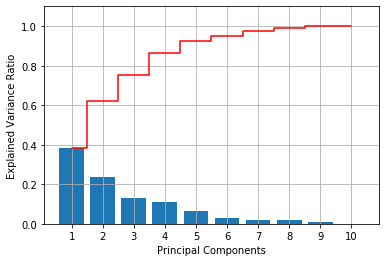

In [15]:
# PCA
pca = PCA(n_components=x_df.shape[1])
pca.fit(x_df)
explained_variance_ratio = pca.explained_variance_ratio_

def explained_variance_ratio_plot(explained_variance_ratio):
    x_axis = range(1, len(explained_variance_ratio)+1)
    plt.bar(x_axis, explained_variance_ratio,
            align = 'center', label = 'Individual Explained Variance Ratio')
    plt.step(x_axis, np.cumsum(explained_variance_ratio),
             where = 'mid', color='red', label='Cumulative Explained Variance Ratio')
    plt.ylim(0, 1.1)
    plt.xticks(x_axis)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    plt.show()

explained_variance_ratio_plot(explained_variance_ratio)

In [16]:
df_v = pd.DataFrame(np.cumsum(explained_variance_ratio[:10]), 
                    index=['PC1','PC2','PC3','PC4','PC5',
                           'PC6','PC7','PC8','PC9','PC10'], 
                    columns=['Cum_V_ration'])

df_v

##주성분 5개 원래 데이터의 약 92% 설명

,Cum_V_ration
PC1,0.383666
PC2,0.621079
PC3,0.752898
PC4,0.861528
PC5,0.924671
PC6,0.952522
PC7,0.973989
PC8,0.992115
PC9,0.999405
PC10,1.000000


In [17]:
printcipalComponents = pca.fit_transform(x_df)
pca_data = pd.DataFrame(printcipalComponents[:,:5], columns = ['PC1','PC2','PC3','PC4','PC5'], index = y)
pca_data

,PC1,PC2,PC3,PC4,PC5
"(수원시, 경기도)",-0.078468,0.432892,3.185238,-0.042145,-0.538097
"(성남시, 경기도)",-0.529171,-0.270477,2.596361,0.192545,-0.275359
"(의정부시, 경기도)",-0.951432,0.255924,0.691781,-0.322221,0.350592
"(안양시, 경기도)",-0.255186,-0.504777,0.664521,-0.131400,0.236085
"(부천시, 경기도)",0.929504,-0.170062,0.934839,0.230117,-1.646390
...,...,...,...,...,...
"(동구, 대구광역시)",-0.459078,0.583338,0.359636,0.608837,1.572568
"(북구, 대구광역시)",0.851741,-1.130213,-0.411106,1.503311,-0.229348
"(서구, 대구광역시)",-0.485319,-0.565995,-1.494097,0.939106,-1.116087
"(수성구, 대구광역시)",-1.960438,-0.302914,1.021412,-0.375766,-0.088328


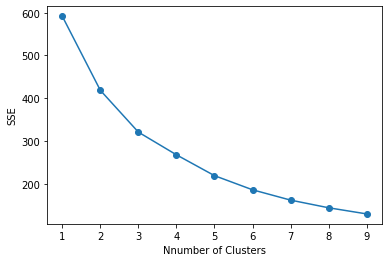

In [18]:
# K-Means
def elbow(x, n):
    sse = []
    for i in range(1, n):
        km = KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(x)
        sse.append(km.inertia_)
    plt.plot(range(1, n), sse, marker='o')
    plt.xlabel('Nnumber of Clusters')
    plt.ylabel('SSE')
    plt.show()
    
elbow(pca_data, 10)

In [19]:
kmeans = KMeans(n_clusters=7).fit(pca_data)
pca_data['cluster_id'] = kmeans.labels_
clust_data = pca_data

In [91]:
for i in range(7):
    print("cluster",i, ":" ,list(clust_data[clust_data['cluster_id']==i].index))
    print(' ')

cluster 0 : [('안산시', '경기도'), ('시흥시', '경기도'), ('파주시', '경기도'), ('안성시', '경기도'), ('김포시', '경기도'), ('화성시', '경기도'), ('광주시', '경기도'), ('양주시', '경기도'), ('포천시', '경기도'), ('달성군', '대구광역시')]
 
cluster 1 : [('의정부시', '경기도'), ('과천시', '경기도'), ('가평군', '경기도'), ('양평군', '경기도'), ('강남구', '서울특별시'), ('관악구', '서울특별시'), ('광진구', '서울특별시'), ('동작구', '서울특별시'), ('마포구', '서울특별시'), ('서대문구', '서울특별시'), ('서초구', '서울특별시'), ('성북구', '서울특별시'), ('송파구', '서울특별시'), ('영등포구', '서울특별시'), ('남구', '대구광역시'), ('수성구', '대구광역시')]
 
cluster 2 : [('강동구', '서울특별시'), ('강북구', '서울특별시'), ('강서구', '서울특별시'), ('노원구', '서울특별시'), ('도봉구', '서울특별시'), ('양천구', '서울특별시'), ('은평구', '서울특별시'), ('중랑구', '서울특별시')]
 
cluster 3 : [('평택시', '경기도'), ('동두천시', '경기도'), ('오산시', '경기도'), ('군포시', '경기도'), ('의왕시', '경기도'), ('이천시', '경기도'), ('여주시', '경기도'), ('연천군', '경기도'), ('달서구', '대구광역시')]
 
cluster 4 : [('하남시', '경기도'), ('용산구', '서울특별시'), ('종로구', '서울특별시'), ('중구', '서울특별시'), ('중구', '대구광역시')]
 
cluster 5 : [('안양시', '경기도'), ('광명시', '경기도'), ('구리시', '경기도'), ('구로구', '서울특별시'), ('금천구', '서울특별시'), ('동대문구'

In [21]:
# 클러스터별 mean
data['cluster_id'] = kmeans.labels_
data.groupby('cluster_id').mean()

,총인구수,서비스업사업체비율,제조업사업체비율,도소매업사업체비율,운수업사업체비율,제조업종사자비율,도소매업종사자비율,운수업종사자비율,합계출산율,도시지역면적
cluster_id,,,,,,,,,,
0,401454.900000,0.587293,0.248165,0.207367,0.097030,0.431256,0.122564,0.046185,1.071400,1.683313e+08
1,353706.000000,0.775714,0.046258,0.233815,0.093997,0.036099,0.148659,0.037956,0.743188,3.864585e+07
2,442912.000000,0.663364,0.055390,0.203067,0.212955,0.056911,0.151334,0.117704,0.728000,2.645875e+07
3,245645.222222,0.686162,0.115345,0.214952,0.110116,0.243726,0.123336,0.064394,1.038000,5.765972e+07
4,171201.400000,0.790324,0.100040,0.413269,0.050235,0.063351,0.235823,0.033432,0.800400,3.118333e+07
5,332787.400000,0.703989,0.118880,0.284423,0.107253,0.139398,0.190004,0.053044,0.835500,4.526448e+07
6,965829.166667,0.722150,0.101127,0.239177,0.101253,0.148740,0.162023,0.047145,0.865833,1.902167e+08


## 2. 서울(중구, 노원구), 대구(중구, 수성구) 비슷한 지역 매칭

In [33]:
s_df = seoul[seoul['시군'].isin(['중구','노원구'])]
d_df = deagu[deagu['시군'].isin(['중구','수성구'])]

In [34]:
df = pd.concat([gg_without_lc, s_df, d_df], axis=0)

In [39]:
# normalizaion
x = df.drop(['시군','시도'], axis=1)
y = df[['시군','시도']].values

trans_x = StandardScaler().fit_transform(x.values)

x_df = pd.DataFrame(trans_x, columns=x.columns)

In [40]:
# PCA
pca = PCA(n_components=x_df.shape[1])
pca.fit(x_df)
explained_variance_ratio = pca.explained_variance_ratio_

In [41]:
df_v = pd.DataFrame(np.cumsum(explained_variance_ratio[:10]), 
                    index=['PC1','PC2','PC3','PC4','PC5',
                           'PC6','PC7','PC8','PC9','PC10'], 
                    columns=['Cum_V_ration'])

df_v

##주성분 5개 원래 데이터의 약 92% 설명

,Cum_V_ration
PC1,0.380357
PC2,0.591176
PC3,0.745687
PC4,0.859346
PC5,0.922010
PC6,0.950999
PC7,0.975593
PC8,0.991339
PC9,0.999388
PC10,1.000000


In [42]:
printcipalComponents = pca.fit_transform(x_df)
pca_df = pd.DataFrame(printcipalComponents[:,:5], columns = ['PC1','PC2','PC3','PC4','PC5'], index = y)
pca_df

,PC1,PC2,PC3,PC4,PC5
"(수원시, 경기도)",-0.783696,1.232833,1.902394,1.155161,0.450204
"(성남시, 경기도)",-1.315536,0.535569,1.892652,0.804458,0.414257
"(의정부시, 경기도)",-1.516497,0.995820,0.045302,0.455544,0.259142
"(안양시, 경기도)",-0.884959,-0.066823,0.164922,0.474979,-0.118336
"(부천시, 경기도)",0.220746,0.085557,0.853419,-0.195460,1.594012
"(광명시, 경기도)",-1.115907,0.735282,-0.601958,-0.726249,0.296933
"(평택시, 경기도)",1.128268,0.078367,0.142824,0.865522,-0.885439
"(동두천시, 경기도)",-0.648246,0.242325,-1.146348,0.569855,0.858680
"(안산시, 경기도)",1.584223,0.270288,0.797616,-0.060508,0.983669
"(고양시, 경기도)",-1.099215,1.446525,2.303288,-0.490404,-0.128615


In [43]:
# row간 거리
distmatrix = pdist(pca_df, metric='euclidean')

In [44]:
row_dist = pd.DataFrame(squareform(distmatrix), columns = pca_df.index,
                       index = pca_df.index)

In [47]:
row_dist

,"(수원시, 경기도)","(성남시, 경기도)","(의정부시, 경기도)","(안양시, 경기도)","(부천시, 경기도)","(광명시, 경기도)","(평택시, 경기도)","(동두천시, 경기도)","(안산시, 경기도)","(고양시, 경기도)",...,"(양주시, 경기도)","(포천시, 경기도)","(여주시, 경기도)","(연천군, 경기도)","(가평군, 경기도)","(양평군, 경기도)","(노원구, 서울특별시)","(중구, 서울특별시)","(수성구, 대구광역시)","(중구, 대구광역시)"
"(수원시, 경기도)",0.000000,0.945204,2.137273,2.346072,2.560853,3.192632,3.154730,3.286901,3.084884,1.829986,...,4.609863,5.907288,4.001309,5.664402,3.707921,3.423145,5.561371,6.390621,2.497772,5.841554
"(성남시, 경기도)",0.945204,0.000000,1.952106,1.981296,2.456488,2.942727,3.306970,3.165334,3.278792,1.736846,...,4.575991,5.792325,3.798796,5.518788,3.421914,3.101069,6.015838,5.512117,1.896337,4.946944
"(의정부시, 경기도)",2.137273,1.952106,0.000000,1.298163,2.589465,1.430161,3.053549,1.764698,3.390883,2.553612,...,4.365186,5.509979,2.767373,4.995477,3.124929,2.288698,4.693162,5.268183,1.632562,4.770486
"(안양시, 경기도)",2.346072,1.981296,1.298163,0.000000,2.258640,1.703001,2.194453,1.683626,2.848151,2.800144,...,3.425100,4.731661,1.881087,3.989289,2.567375,1.664820,5.586340,4.933890,2.185959,4.341667
"(부천시, 경기도)",2.560853,2.456488,2.589465,2.258640,0.000000,2.508197,2.932909,2.430063,1.512297,2.958223,...,2.904998,3.564289,3.118436,5.332739,3.911466,3.484284,5.690248,5.727728,3.044855,5.503889
"(광명시, 경기도)",3.192632,2.942727,1.430161,1.703001,2.508197,0.000000,3.155043,1.659373,3.221885,3.030398,...,3.803056,4.783405,2.430284,5.076203,3.877902,2.833784,4.472299,4.820294,2.548299,4.686035
"(평택시, 경기도)",3.154730,3.306970,3.053549,2.194453,2.932909,3.155043,0.000000,2.823866,2.241557,3.729942,...,2.347656,4.261897,2.091391,3.275882,3.505568,2.870357,5.813193,6.648341,4.255233,6.123404
"(동두천시, 경기도)",3.286901,3.165334,1.764698,1.683626,2.430063,1.659373,2.823866,0.000000,3.029302,3.956306,...,3.544865,4.300519,1.729663,4.181128,2.750624,1.951129,4.993860,5.577942,2.703621,5.046110
"(안산시, 경기도)",3.084884,3.278792,3.390883,2.848151,1.512297,3.221885,2.241557,3.029302,0.000000,3.503343,...,1.974524,3.129491,3.160606,5.004684,4.436602,3.988955,5.712483,6.760603,4.274151,6.542261
"(고양시, 경기도)",1.829986,1.736846,2.553612,2.800144,2.958223,3.030398,3.729942,3.956306,3.503343,0.000000,...,4.811572,6.183863,4.484587,6.453989,4.934416,4.304173,5.432843,5.715481,2.960639,5.598989


In [69]:
for i in row_dist.columns:
    print(i, row_dist[i].nsmallest(2).index[1])

('수원시', '경기도') ('성남시', '경기도')
('성남시', '경기도') ('수원시', '경기도')
('의정부시', '경기도') ('안양시', '경기도')
('안양시', '경기도') ('의정부시', '경기도')
('부천시', '경기도') ('안산시', '경기도')
('광명시', '경기도') ('구리시', '경기도')
('평택시', '경기도') ('파주시', '경기도')
('동두천시', '경기도') ('오산시', '경기도')
('안산시', '경기도') ('부천시', '경기도')
('고양시', '경기도') ('성남시', '경기도')
('과천시', '경기도') ('수성구', '대구광역시')
('구리시', '경기도') ('광명시', '경기도')
('남양주시', '경기도') ('고양시', '경기도')
('오산시', '경기도') ('이천시', '경기도')
('시흥시', '경기도') ('김포시', '경기도')
('군포시', '경기도') ('이천시', '경기도')
('의왕시', '경기도') ('이천시', '경기도')
('하남시', '경기도') ('구리시', '경기도')
('용인시', '경기도') ('남양주시', '경기도')
('파주시', '경기도') ('안성시', '경기도')
('이천시', '경기도') ('군포시', '경기도')
('안성시', '경기도') ('파주시', '경기도')
('김포시', '경기도') ('시흥시', '경기도')
('화성시', '경기도') ('시흥시', '경기도')
('광주시', '경기도') ('파주시', '경기도')
('양주시', '경기도') ('김포시', '경기도')
('포천시', '경기도') ('김포시', '경기도')
('여주시', '경기도') ('동두천시', '경기도')
('연천군', '경기도') ('여주시', '경기도')
('가평군', '경기도') ('양평군', '경기도')
('양평군', '경기도') ('가평군', '경기도')
('노원구', '서울특별시') ('의왕시', '경기도')
('중구', '서울특별시') ('중구', '대구광역시'

In [83]:
print("노원구, 서울특별시와 가장 유사한 지역  ==> ", row_dist.iloc[-4].nsmallest(2).index[1])
print("  중구, 서울특별시와 가장 유사한 지역  ==> ", row_dist.iloc[-3].nsmallest(3).index[2])
print("수성구, 대구광역시와 가장 유사한 지역  ==> ", row_dist.iloc[-2].nsmallest(2).index[1])
print("  중구, 대구광역시와 가장 유사한 지역  ==> ", row_dist.iloc[-1].nsmallest(3).index[2])

노원구, 서울특별시와 가장 유사한 지역  ==>  ('의왕시', '경기도')
  중구, 서울특별시와 가장 유사한 지역  ==>  ('하남시', '경기도')
수성구, 대구광역시와 가장 유사한 지역  ==>  ('과천시', '경기도')
  중구, 대구광역시와 가장 유사한 지역  ==>  ('과천시', '경기도')
